# Push Pull Examples

In [9]:
import sys
sys.path.insert(0, '..')

import torch
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import networkx as nx

import objective
import constraint
import push_pull

import plot2d

### Gradient Implementation
In push-pull (and other distributed optimization algorithms) agents can only evaluate their own gradients. Hence, it would make sense that each row of `x.grad` contains the gradients of the agent that corresponds to that row. Thus, after the calls
```
    objectives = ...
    m = MultiAgentObjective(objectives)
    obj = m(x)
    multi_backward(obj)
```

`x.grad` will contain the gradients $\nabla f_i(x_i)$. ie. `x.grad[i]` is $\nabla f_i(x_i)$. Below is a sample implementation of gradient descent for each agent simultaneously

In [10]:
n_agents = 4 
P = torch.tensor([[5, 0], 
                  [0, 1]], dtype=torch.float64, requires_grad = False)

objectives = []
for i in range(n_agents):
    xi = torch.tensor([i+1, i+1], dtype=torch.float64, requires_grad=False)
    qi = objective.QuadraticObjective(P, xi)
    objectives.append(qi)

### Graph Implementation

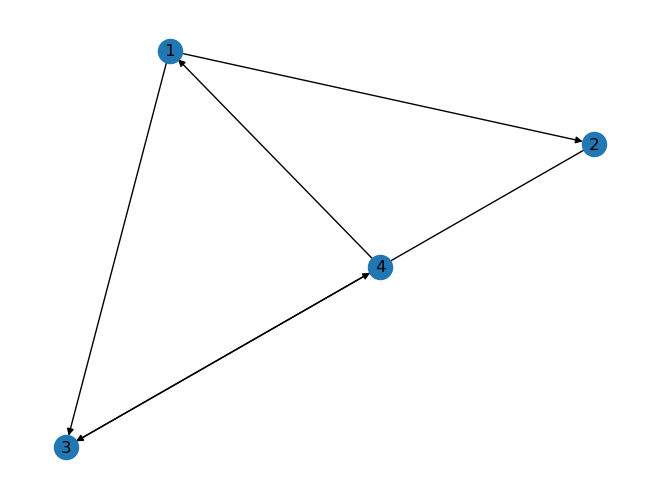

In [11]:
G = nx.DiGraph()
G.add_nodes_from(list(range(1, n_agents+1)))
G.add_edges_from([(1,2), (2,3), (3,4), (4,1), (1,3)])

A = torch.tensor(nx.to_numpy_array(G))

nx.draw(G, with_labels=True)

In [12]:
R, C = push_pull.Helpers.construct_RC(A)
phi, pi = push_pull.Helpers.find_eigenvectors(R, C)

In [13]:
x = torch.tensor([[8, 8],
                  [10, 10],
                  [6, 6],
                  [7, 7]], dtype = torch.float64, requires_grad=True)

num_iterations = 100
eta = 0.05

m = objective.MultiAgentObjective(objectives)
# constraints = constraint.RectangleConstraint([[5, 500], [-10000,10000]])

circle_center = torch.Tensor([6, 6])
radius = 2
constraints = constraint.SphericalConstraint(circle_center, radius)

data = push_pull.simulate_push_pull(R, C, m, cnstr=constraints, x_init=x, eta=eta, num_iterations = num_iterations)

Note: The reason the optimality error is not going to 0 is because the point $x^*$ is also computed using gradient descent. There is a parameter $\epsilon$ that controls how accurate the optimal point estimate $x^*$ should be and ideally the optimality error should be not greater than $\epsilon$. If you have a better estimate of $x^*$, the optimality error should also decrease.

The error terms are 
- Consensus Error: $D(x[k], \phi)$
- Gradient Error: $S(y[k], \pi)$
- Optimality Error: $\|\hat x[k] - x^*\|$


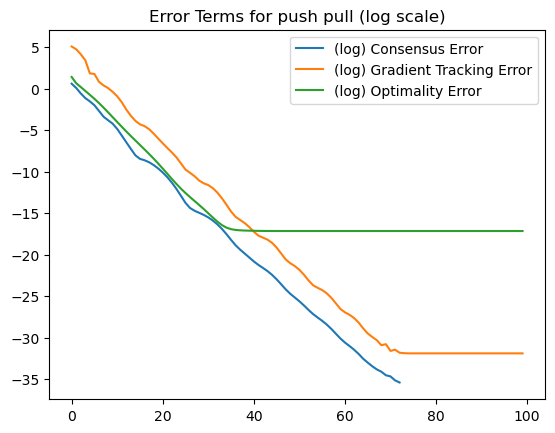

In [14]:
consensus_errors = data['consensus_error']
gradient_errors = data['grad_error']
optimality_errors = data['optimality_gap']

xs = data['xs']
ys = data['ys']
xs= torch.stack(xs).permute(1, 0, 2)
ys = torch.stack(ys).permute(1, 0, 2)

plt.title('Error Terms for push pull (log scale)')
plt.plot(list(range(len(consensus_errors))), torch.log(consensus_errors), label='(log) Consensus Error')
plt.plot(list(range(len(gradient_errors))), torch.log(gradient_errors), label='(log) Gradient Tracking Error')
plt.plot(list(range(len(optimality_errors))), torch.log(optimality_errors), label='(log) Optimality Error')
plt.legend()
plt.show()

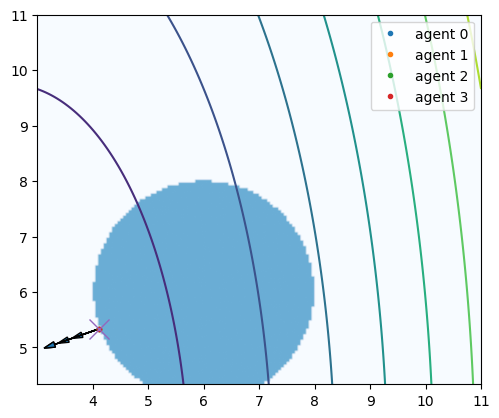

In [15]:

# determine the range for the plot
xr_min, xr_max = xs[:, :, 0].min(), xs[:, :, 0].max()
yr_min, yr_max = xs[:, :, 1].min(), xs[:, :, 1].max()


fig = plt.figure()

# plot the problem (contour lines and constraint set)
plot2d.plot_problem_2d(m, constraints, rng = [[xr_min, xr_max], [yr_min, yr_max]], cell_size=0.05)

#
# TODO, fix the case when the points are out of range of the problem plot
#
# also, make this part an animation
#
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Projected Push Pull Optimization')
writer = FFMpegWriter(fps=5, metadata=metadata)

agent_xs = [None for i in range(n_agents)]
agent_ys = [None for i in range(n_agents)]
for agent in range(n_agents):
    agent_xs[agent], = plt.plot([], [], '.', label=f'agent {agent}')
    agent_ys[agent] = plt.arrow([], [], [], [], length_includes_head=True,
          head_width=0.1, head_length=0.2)

x_star = m.optimum(constraints=constraints).detach().clone()

plt.plot(x_star[0], x_star[1], 'x', markersize=15)
plt.legend()

y_scaled = True

# Update the frames for the movie
with writer.saving(fig, "push_pull.mp4", 100):
    for iteration in range(num_iterations):
        for i in range(n_agents):
            xi = xs[i][iteration, 0]
            yi = xs[i][iteration, 1]
            grad_x = ys[i][iteration, 0]
            grad_y = ys[i][iteration, 1]

            agent_xs[i].set_data(xi, yi)
            # set the gradients
            if y_scaled:
                agent_ys[i].set_data(x=xi,y=yi, dx=-eta*grad_x, dy=-eta*grad_y)
            else:
                agent_ys[i].set_data(x=xi,y=yi, dx=-grad_x, dy=-grad_y)
            

        writer.grab_frame()

In [16]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="push_pull.mp4" type="video/mp4">
</video></div>""")